In [15]:
# ============================================================
# FLIP DETECTOR & DATASET CLEANER
# Copy-paste these cells at the START of your Kaggle notebook
# Run these BEFORE the anomaly detection code
# ============================================================

# ============================================================
# CELL 1: Flip Detector Setup
# ============================================================

import numpy as np
import os
import shutil
from tqdm import tqdm
import random
import json

from PIL import Image
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")

# Paths
TRAIN_PATH = '/kaggle/input/pixel-play-26/Avenue_Corrupted-20251221T112159Z-3-001/Avenue_Corrupted/Dataset/training_videos'
TEST_PATH_ORIGINAL = '/kaggle/input/pixel-play-26/Avenue_Corrupted-20251221T112159Z-3-001/Avenue_Corrupted/Dataset/testing_videos'
CLEAN_TEST_PATH = '/kaggle/working/cleaned_testing_videos'

# Flip detector config
FLIP_IMG_SIZE = 64
FLIP_BATCH_SIZE = 64
FLIP_EPOCHS = 5
FLIP_LR = 0.001

print(f"Train path exists: {os.path.exists(TRAIN_PATH)}")
print(f"Test path exists: {os.path.exists(TEST_PATH_ORIGINAL)}")


# ============================================================
# CELL 2: Flip Detection Dataset
# ============================================================

class FlipDetectionDataset(Dataset):
    def __init__(self, video_path, img_size=64, samples_per_class=3000):
        self.img_size = img_size
        self.transform = transforms.Compose([
            transforms.Resize((img_size, img_size)),
            transforms.ToTensor(),
        ])
        
        # Collect all frame paths
        self.frame_paths = []
        video_folders = [f for f in os.listdir(video_path) if os.path.isdir(os.path.join(video_path, f))]
        for folder in video_folders:
            folder_path = os.path.join(video_path, folder)
            frames = [f for f in os.listdir(folder_path) if f.endswith(('.jpg', '.png'))]
            for frame in frames:
                self.frame_paths.append(os.path.join(folder_path, frame))
        
        print(f"Total frames available: {len(self.frame_paths)}")
        
        # Sample frames
        if len(self.frame_paths) > samples_per_class:
            selected = random.sample(self.frame_paths, samples_per_class)
        else:
            selected = self.frame_paths
        
        # Each frame: normal (0) and flipped (1)
        self.samples = []
        for path in selected:
            self.samples.append((path, 0))
            self.samples.append((path, 1))
        random.shuffle(self.samples)
        print(f"Training samples: {len(self.samples)}")
    
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        path, label = self.samples[idx]
        img = Image.open(path).convert('L')
        img_tensor = self.transform(img)
        if label == 1:
            img_tensor = TF.vflip(img_tensor)
        return img_tensor, torch.tensor(label, dtype=torch.long)

print("Creating flip detection dataset...")
flip_dataset = FlipDetectionDataset(TRAIN_PATH, FLIP_IMG_SIZE, samples_per_class=3000)
flip_loader = DataLoader(flip_dataset, batch_size=FLIP_BATCH_SIZE, shuffle=True, num_workers=2)
print(f"Batches: {len(flip_loader)}")


# ============================================================
# CELL 3: Flip Detector CNN Model
# ============================================================

class FlipDetectorCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d(1),
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(32, 2),
        )
    
    def forward(self, x):
        return self.classifier(self.features(x))

flip_model = FlipDetectorCNN().to(device)
print(f"Flip Detector: {sum(p.numel() for p in flip_model.parameters()):,} parameters")


# ============================================================
# CELL 4: Train Flip Detector
# ============================================================

flip_criterion = nn.CrossEntropyLoss()
flip_optimizer = optim.Adam(flip_model.parameters(), lr=FLIP_LR)

print("Training flip detector...")
flip_model.train()

for epoch in range(FLIP_EPOCHS):
    total_loss = 0
    correct = 0
    total = 0
    
    pbar = tqdm(flip_loader, desc=f'Flip Detector Epoch {epoch+1}/{FLIP_EPOCHS}')
    for images, labels in pbar:
        images, labels = images.to(device), labels.to(device)
        
        outputs = flip_model(images)
        loss = flip_criterion(outputs, labels)
        
        flip_optimizer.zero_grad()
        loss.backward()
        flip_optimizer.step()
        
        total_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
        
        pbar.set_postfix({'loss': f'{loss.item():.4f}', 'acc': f'{100*correct/total:.1f}%'})
    
    print(f'Epoch {epoch+1}: Loss={total_loss/len(flip_loader):.4f}, Accuracy={100*correct/total:.1f}%')

torch.save(flip_model.state_dict(), 'flip_detector.pth')
print("Saved: flip_detector.pth")


# ============================================================
# CELL 5: Scan Test Dataset for Flipped Frames
# ============================================================

def detect_flipped_frames(model, test_path, img_size=64, threshold=0.5):
    model.eval()
    transform = transforms.Compose([
        transforms.Resize((img_size, img_size)),
        transforms.ToTensor(),
    ])
    
    results = {}
    flipped_count = 0
    total_count = 0
    
    video_folders = sorted([f for f in os.listdir(test_path) if os.path.isdir(os.path.join(test_path, f))])
    
    with torch.no_grad():
        for folder in tqdm(video_folders, desc='Scanning for flipped frames'):
            folder_path = os.path.join(test_path, folder)
            frames = sorted([f for f in os.listdir(folder_path) if f.endswith(('.jpg', '.png'))])
            
            results[folder] = {}
            
            for frame_name in frames:
                frame_path = os.path.join(folder_path, frame_name)
                img = Image.open(frame_path).convert('L')
                img_tensor = transform(img).unsqueeze(0).to(device)
                
                output = model(img_tensor)
                prob = torch.softmax(output, dim=1)
                flip_prob = prob[0, 1].item()
                
                is_flipped = flip_prob > threshold
                results[folder][frame_name] = {'is_flipped': is_flipped, 'flip_prob': flip_prob}
                
                if is_flipped:
                    flipped_count += 1
                total_count += 1
    
    print(f"\nScan Results:")
    print(f"  Total frames: {total_count}")
    print(f"  Flipped frames: {flipped_count} ({100*flipped_count/total_count:.1f}%)")
    
    return results, flipped_count

print("\nScanning test dataset...")
flip_results, num_flipped = detect_flipped_frames(flip_model, TEST_PATH_ORIGINAL, FLIP_IMG_SIZE)


# ============================================================
# CELL 6: Create Cleaned Test Dataset
# ============================================================

def create_clean_dataset(test_path, clean_path, flip_results):
    if os.path.exists(clean_path):
        shutil.rmtree(clean_path)
    os.makedirs(clean_path)
    
    corrected_count = 0
    copied_count = 0
    
    for folder in tqdm(flip_results.keys(), desc='Creating clean dataset'):
        src_folder = os.path.join(test_path, folder)
        dst_folder = os.path.join(clean_path, folder)
        os.makedirs(dst_folder, exist_ok=True)
        
        for frame_name, info in flip_results[folder].items():
            src_path = os.path.join(src_folder, frame_name)
            dst_path = os.path.join(dst_folder, frame_name)
            
            if info['is_flipped']:
                img = Image.open(src_path)
                img_corrected = TF.vflip(transforms.ToTensor()(img))
                img_corrected = transforms.ToPILImage()(img_corrected)
                img_corrected.save(dst_path)
                corrected_count += 1
            else:
                shutil.copy2(src_path, dst_path)
                copied_count += 1
    
    print(f"\nClean dataset created: {clean_path}")
    print(f"  Corrected: {corrected_count}")
    print(f"  Copied: {copied_count}")
    
    return corrected_count, copied_count

print("\nCreating cleaned dataset...")
corrected, copied = create_clean_dataset(TEST_PATH_ORIGINAL, CLEAN_TEST_PATH, flip_results)


# ============================================================
# CELL 7: Visualize Results
# ============================================================

# Get list of flipped frames
flipped_frames = []
for folder, frames in flip_results.items():
    for frame_name, info in frames.items():
        if info['is_flipped']:
            flipped_frames.append((folder, frame_name, info['flip_prob']))

flipped_frames.sort(key=lambda x: x[2], reverse=True)

print(f"\nTop 10 flipped frames:")
for folder, frame, prob in flipped_frames[:10]:
    print(f"  {folder}/{frame}: {prob:.4f}")

# Visualize
if len(flipped_frames) > 0:
    fig, axes = plt.subplots(2, 5, figsize=(15, 6))
    
    for i in range(min(5, len(flipped_frames))):
        folder, frame_name, prob = flipped_frames[i]
        
        # Original
        orig_path = os.path.join(TEST_PATH_ORIGINAL, folder, frame_name)
        orig_img = Image.open(orig_path).convert('L')
        axes[0, i].imshow(orig_img, cmap='gray')
        axes[0, i].set_title(f'Original\nP={prob:.2f}')
        axes[0, i].axis('off')
        
        # Cleaned
        clean_path = os.path.join(CLEAN_TEST_PATH, folder, frame_name)
        clean_img = Image.open(clean_path).convert('L')
        axes[1, i].imshow(clean_img, cmap='gray')
        axes[1, i].set_title('Corrected')
        axes[1, i].axis('off')
    
    plt.suptitle('Original vs Corrected Frames', fontsize=14)
    plt.tight_layout()
    plt.savefig('flip_correction_comparison.png', dpi=150)
    plt.show()

print("\n" + "="*60)
print("FLIP DETECTION COMPLETE!")
print("="*60)
print(f"Flipped frames detected: {num_flipped}")
print(f"Cleaned dataset: {CLEAN_TEST_PATH}")
print("="*60)


# ============================================================
# CELL 8: UPDATE TEST_PATH FOR ANOMALY DETECTION
# ============================================================

# IMPORTANT: This sets TEST_PATH to use the cleaned dataset
# The anomaly detection code below will use this path

TEST_PATH = CLEAN_TEST_PATH
print(f"\n*** TEST_PATH is now set to: {TEST_PATH} ***")
print("Anomaly detection will use the CLEANED dataset!\n")


# ============================================================
# NOW CONTINUE WITH YOUR ANOMALY DETECTION CODE BELOW
# (from pixelplay_v2_fixed.ipynb)
# 
# The TEST_PATH variable is already set to the cleaned dataset
# ============================================================

Device: cuda
Train path exists: True
Test path exists: True
Creating flip detection dataset...
Total frames available: 9204
Training samples: 6000
Batches: 94
Flip Detector: 25,442 parameters
Training flip detector...


Flip Detector Epoch 1/5:  11%|█         | 10/94 [00:01<00:10,  7.82it/s, loss=0.6912, acc=48.3%]


KeyboardInterrupt: 

# Pixel Play'26: Fully Configurable Anomaly Detection

## Features:
- **Configurable data augmentation** (normal/noisy/flipped percentages)
- **Configurable temporal length** (1 to 20+ frames per cuboid)
- **Configurable stride/sliding window**
- **Load pretrained model** option
- **Auto-zip all outputs**

## Note:
- `TEMPORAL_LENGTH = 1`: Single-frame autoencoder (no temporal info)
- `TEMPORAL_LENGTH > 1`: Temporal cuboid autoencoder (captures motion)

---
## 1. CONFIGURATION
---

In [16]:
# ╔════════════════════════════════════════════════════════════════╗
# ║                    CONFIGURATION                               ║
# ╚════════════════════════════════════════════════════════════════╝

# ============== DATA AUGMENTATION ==============
NORMAL_PERCENT =60     # % of normal frames (must sum to 100)
NOISY_PERCENT = 40      # % of noisy frames
FLIPPED_PERCENT = 0    # % of flipped frames
NOISE_FACTOR = 0.1373     # Noise intensity (0.1=light, 0.3=heavy)

# ============== TEMPORAL SETTINGS ==============
TEMPORAL_LENGTH = 16  # Frames per cuboid (1 = single frame, 10 = temporal)
STRIDE = 2               # Sliding window stride
# ============== TRAINING ==============
IMG_SIZE = 128
BATCH_SIZE = 32
EPOCHS = 25
LEARNING_RATE = 0.001
WEIGHT_DECAY = 1e-4

# ============== PRETRAINED MODEL ==============
LOAD_PRETRAINED = False
PRETRAINED_PATH = '/kaggle/input/128dataset/trained_model.pth'

# ============== OUTPUT ==============
OUTPUT_ZIP_NAME = 'output_results.zip'
MODEL_SAVE_NAME = 'trained_model.pth'

In [17]:
# Validate
assert NORMAL_PERCENT + NOISY_PERCENT + FLIPPED_PERCENT == 100, "Percentages must sum to 100!"
assert TEMPORAL_LENGTH >= 1, "TEMPORAL_LENGTH must be >= 1"
assert STRIDE >= 1, "STRIDE must be >= 1"

print("="*50)
print("CONFIGURATION")
print("="*50)
print(f"Augmentation: {NORMAL_PERCENT}% normal, {NOISY_PERCENT}% noisy, {FLIPPED_PERCENT}% flipped")
print(f"Temporal: {TEMPORAL_LENGTH} frames, Stride: {STRIDE}")
print(f"Training: {EPOCHS} epochs, LR: {LEARNING_RATE}")
print(f"Pretrained: {LOAD_PRETRAINED}")
if TEMPORAL_LENGTH == 1:
    print("\n⚠️  TEMPORAL_LENGTH=1: Single-frame mode (no temporal info)")
print("="*50)

CONFIGURATION
Augmentation: 60% normal, 40% noisy, 0% flipped
Temporal: 16 frames, Stride: 2
Training: 25 epochs, LR: 0.001
Pretrained: False


---
## 2. Setup
---

In [18]:
import numpy as np
import pandas as pd
import os
import random
import zipfile
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

from PIL import Image
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF

SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)
random.seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")

Device: cuda


In [19]:
TRAIN_PATH = '/kaggle/input/pixel-play-26/Avenue_Corrupted-20251221T112159Z-3-001/Avenue_Corrupted/Dataset/training_videos'
TEST_PATH = '/kaggle/working/cleaned_testing_videos'
print(f"Train path exists: {os.path.exists(TRAIN_PATH)}")
print(f"Test path exists: {os.path.exists(TEST_PATH)}")

Train path exists: True
Test path exists: True


---
## 3. Augmentation
---

In [20]:
def add_gaussian_noise(tensor, noise_factor=0.1373):
    """
    tensor: input in [0,1], shape (B,1,H,W) or (B,C,H,W)
    noise_factor: max deviation in normalized units
                  (35 / 255 ≈ 0.1373)
    """
    noise = torch.empty_like(tensor).uniform_(-noise_factor, noise_factor)
    return torch.clamp(tensor + noise, 0.0, 1.0)


def vertical_flip(tensor):
    return TF.vflip(tensor)

def apply_augmentation(tensor, aug_type, noise_factor=0.2):
    if aug_type == 'normal':
        return tensor
    elif aug_type == 'noisy':
        return add_gaussian_noise(tensor, noise_factor)
    elif aug_type == 'flipped':
        return vertical_flip(tensor)
    else:
        return tensor

print("Augmentation functions ready!")

Augmentation functions ready!


---
## 4. Dataset
---

In [22]:
class AugmentedVideoDataset(Dataset):
    def __init__(self, video_path, temporal_length=10, stride=1, img_size=128,
                 normal_percent=50, noisy_percent=25, flipped_percent=25,
                 noise_factor=0.2, is_test=False):
        self.video_path = video_path
        self.temporal_length = temporal_length
        self.stride = stride
        self.img_size = img_size
        self.noise_factor = noise_factor
        self.is_test = is_test
        self.normal_percent = normal_percent
        self.noisy_percent = noisy_percent
        
        self.transform = transforms.Compose([
            transforms.Resize((img_size, img_size)),
            transforms.ToTensor()
        ])
        
        self.samples = []
        self._prepare_samples()
    
    def _prepare_samples(self):
        video_folders = sorted([f for f in os.listdir(self.video_path)
                               if os.path.isdir(os.path.join(self.video_path, f))])
        
        all_cuboids = []
        for folder in video_folders:
            folder_path = os.path.join(self.video_path, folder)
            frames = sorted([f for f in os.listdir(folder_path) if f.endswith(('.jpg', '.png'))])
            max_start = len(frames) - self.temporal_length
            for start_idx in range(0, max_start + 1, self.stride):
                all_cuboids.append((folder, start_idx))
        
        if self.is_test:
            self.samples = [(f, i, 'normal') for f, i in all_cuboids]
        else:
            random.shuffle(all_cuboids)
            total = len(all_cuboids)
            normal_count = int(total * self.normal_percent / 100)
            noisy_count = int(total * self.noisy_percent / 100)
            
            for i, (folder, idx) in enumerate(all_cuboids):
                if i < normal_count:
                    aug = 'normal'
                elif i < normal_count + noisy_count:
                    aug = 'noisy'
                else:
                    aug = 'flipped'
                self.samples.append((folder, idx, aug))
            random.shuffle(self.samples)
        
        print(f"Dataset: {len(self.samples)} samples (T={self.temporal_length}, stride={self.stride})")
    
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        folder, start_idx, aug_type = self.samples[idx]
        folder_path = os.path.join(self.video_path, folder)
        frames = sorted([f for f in os.listdir(folder_path) if f.endswith(('.jpg', '.png'))])
        
        cuboid = []
        for i in range(self.temporal_length):
            img = Image.open(os.path.join(folder_path, frames[start_idx + i])).convert('L')
            img_tensor = self.transform(img)
            img_tensor = apply_augmentation(img_tensor, aug_type, self.noise_factor)
            cuboid.append(img_tensor)
        
        return torch.cat(cuboid, dim=0)

In [23]:
print("Creating training dataset...")
train_dataset = AugmentedVideoDataset(
    TRAIN_PATH, TEMPORAL_LENGTH, STRIDE, IMG_SIZE,
    NORMAL_PERCENT, NOISY_PERCENT, FLIPPED_PERCENT, NOISE_FACTOR, is_test=False
)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
print(f"Batches: {len(train_loader)}")

Creating training dataset...
Dataset: 4486 samples (T=16, stride=2)
Batches: 141


---
## 5. Model
---

In [24]:
class ConvAutoencoder(nn.Module):
    def __init__(self, temporal_length=10):
        super().__init__()
        self.temporal_length = temporal_length
        
        self.encoder = nn.Sequential(
            nn.Conv2d(temporal_length, 64, 4, 2, 1), nn.BatchNorm2d(64), nn.ReLU(True), nn.Dropout2d(0.2),
            nn.Conv2d(64, 128, 4, 2, 1), nn.BatchNorm2d(128), nn.ReLU(True), nn.Dropout2d(0.2),
            nn.Conv2d(128, 256, 4, 2, 1), nn.BatchNorm2d(256), nn.ReLU(True), nn.Dropout2d(0.2),
            nn.Conv2d(256, 512, 4, 2, 1), nn.BatchNorm2d(512), nn.ReLU(True),  # No dropout on last
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(512, 256, 4, 2, 1), nn.BatchNorm2d(256), nn.ReLU(True),
            nn.ConvTranspose2d(256, 128, 4, 2, 1), nn.BatchNorm2d(128), nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, 4, 2, 1), nn.BatchNorm2d(64), nn.ReLU(True),
            nn.ConvTranspose2d(64, temporal_length, 4, 2, 1), nn.Sigmoid(),
        )
    
    def forward(self, x):
        return self.decoder(self.encoder(x))

model = ConvAutoencoder(TEMPORAL_LENGTH).to(device)
print(f"Model: {sum(p.numel() for p in model.parameters()):,} parameters")

Model: 5,542,032 parameters


In [25]:
if LOAD_PRETRAINED and os.path.exists(PRETRAINED_PATH):
    model.load_state_dict(torch.load(PRETRAINED_PATH, map_location=device))
    print(f"Loaded pretrained model: {PRETRAINED_PATH}")
elif LOAD_PRETRAINED:
    print(f"WARNING: {PRETRAINED_PATH} not found, training from scratch")
    LOAD_PRETRAINED = False

---
## 6. Training
---

In [26]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

def train_model(model, loader, criterion, optimizer, epochs):
    model.train()
    history = []
    for epoch in range(epochs):
        total_loss = 0
        for batch in tqdm(loader, desc=f'Epoch {epoch+1}/{epochs}'):
            batch = batch.to(device)
            output = model(batch)
            loss = criterion(output, batch)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        avg_loss = total_loss / len(loader)
        history.append(avg_loss)
        print(f'Epoch {epoch+1}: Loss = {avg_loss:.6f}')
    return history


Training with T=16, Stride=2


Epoch 1/25: 100%|██████████| 141/141 [02:13<00:00,  1.06it/s]


Epoch 1: Loss = 0.010825


Epoch 2/25: 100%|██████████| 141/141 [02:13<00:00,  1.05it/s]


Epoch 2: Loss = 0.004235


Epoch 3/25: 100%|██████████| 141/141 [02:15<00:00,  1.04it/s]


Epoch 3: Loss = 0.004438


Epoch 4/25: 100%|██████████| 141/141 [02:16<00:00,  1.04it/s]


Epoch 4: Loss = 0.014522


Epoch 5/25: 100%|██████████| 141/141 [02:13<00:00,  1.05it/s]


Epoch 5: Loss = 0.006851


Epoch 6/25: 100%|██████████| 141/141 [02:15<00:00,  1.04it/s]


Epoch 6: Loss = 0.004501


Epoch 7/25: 100%|██████████| 141/141 [02:14<00:00,  1.05it/s]


Epoch 7: Loss = 0.003996


Epoch 8/25: 100%|██████████| 141/141 [02:17<00:00,  1.02it/s]


Epoch 8: Loss = 0.003809


Epoch 9/25: 100%|██████████| 141/141 [02:17<00:00,  1.02it/s]


Epoch 9: Loss = 0.003658


Epoch 10/25: 100%|██████████| 141/141 [02:17<00:00,  1.02it/s]


Epoch 10: Loss = 0.003646


Epoch 11/25: 100%|██████████| 141/141 [02:15<00:00,  1.04it/s]


Epoch 11: Loss = 0.003508


Epoch 12/25: 100%|██████████| 141/141 [02:17<00:00,  1.03it/s]


Epoch 12: Loss = 0.003464


Epoch 13/25: 100%|██████████| 141/141 [02:21<00:00,  1.00s/it]


Epoch 13: Loss = 0.014838


Epoch 14/25: 100%|██████████| 141/141 [02:18<00:00,  1.01it/s]


Epoch 14: Loss = 0.006377


Epoch 15/25: 100%|██████████| 141/141 [02:14<00:00,  1.05it/s]


Epoch 15: Loss = 0.004477


Epoch 16/25: 100%|██████████| 141/141 [02:15<00:00,  1.04it/s]


Epoch 16: Loss = 0.003959


Epoch 17/25: 100%|██████████| 141/141 [02:14<00:00,  1.05it/s]


Epoch 17: Loss = 0.003744


Epoch 18/25: 100%|██████████| 141/141 [02:11<00:00,  1.07it/s]


Epoch 18: Loss = 0.003635


Epoch 19/25: 100%|██████████| 141/141 [02:14<00:00,  1.05it/s]


Epoch 19: Loss = 0.003546


Epoch 20/25: 100%|██████████| 141/141 [02:13<00:00,  1.06it/s]


Epoch 20: Loss = 0.003517


Epoch 21/25: 100%|██████████| 141/141 [02:14<00:00,  1.05it/s]


Epoch 21: Loss = 0.003531


Epoch 22/25: 100%|██████████| 141/141 [02:14<00:00,  1.05it/s]


Epoch 22: Loss = 0.003467


Epoch 23/25: 100%|██████████| 141/141 [02:12<00:00,  1.06it/s]


Epoch 23: Loss = 0.003441


Epoch 24/25: 100%|██████████| 141/141 [02:13<00:00,  1.05it/s]


Epoch 24: Loss = 0.003436


Epoch 25/25: 100%|██████████| 141/141 [02:11<00:00,  1.07it/s]


Epoch 25: Loss = 0.003402
Model saved: trained_model.pth


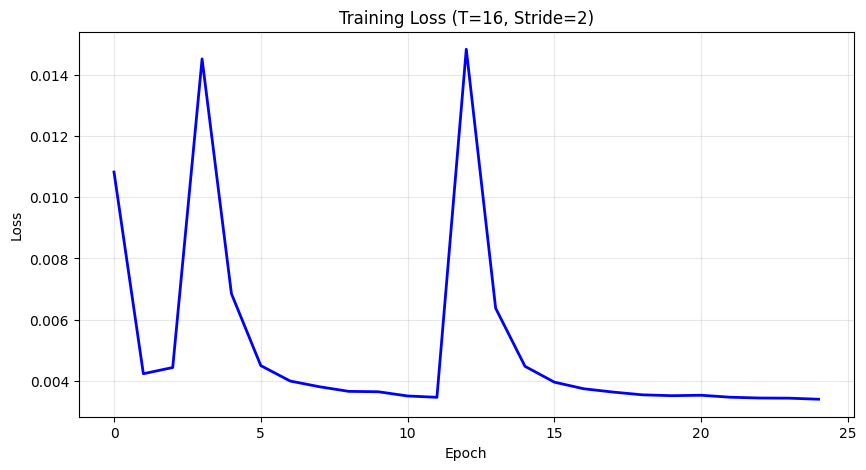

In [27]:
if not LOAD_PRETRAINED:
    print(f"\nTraining with T={TEMPORAL_LENGTH}, Stride={STRIDE}")
    history = train_model(model, train_loader, criterion, optimizer, EPOCHS)
    torch.save(model.state_dict(), MODEL_SAVE_NAME)
    print(f"Model saved: {MODEL_SAVE_NAME}")
    
    plt.figure(figsize=(10, 5))
    plt.plot(history, 'b-', linewidth=2)
    plt.xlabel('Epoch'); plt.ylabel('Loss')
    plt.title(f'Training Loss (T={TEMPORAL_LENGTH}, Stride={STRIDE})')
    plt.grid(True, alpha=0.3)
    plt.savefig('training_curve.png', dpi=150)
    plt.show()
else:
    print("Skipping training (pretrained model loaded)")
    history = []

---
## 7. Predictions
---

In [28]:
def predict_video(model, video_path, temporal_length, img_size, device):
    """
    Compute reconstruction error for all frames.
    Works with temporal_length=1 (single frame) and >1 (temporal cuboid).
    """
    model.eval()
    transform = transforms.Compose([transforms.Resize((img_size, img_size)), transforms.ToTensor()])
    
    frames = sorted([f for f in os.listdir(video_path) if f.endswith(('.jpg', '.png'))])
    frame_errors = {i: [] for i in range(len(frames))}
    
    with torch.no_grad():
        for start_idx in range(len(frames) - temporal_length + 1):
            cuboid = []
            for i in range(temporal_length):
                img = Image.open(os.path.join(video_path, frames[start_idx + i])).convert('L')
                cuboid.append(transform(img))
            
            cuboid = torch.cat(cuboid, dim=0).unsqueeze(0).to(device)
            output = model(cuboid)
            
            # Per-frame error
            error = (cuboid - output).pow(2).mean(dim=[2, 3]).squeeze().cpu().numpy()
            
            # Handle temporal_length=1 (scalar) vs >1 (array)
            if temporal_length == 1:
                frame_errors[start_idx].append(float(error))
            else:
                error = np.atleast_1d(error)  # Ensure it's always an array
                for i in range(temporal_length):
                    frame_errors[start_idx + i].append(error[i])
    
    return {idx: np.mean(errs) if errs else 0.0 for idx, errs in frame_errors.items()}

In [29]:
print("Processing test videos...")
raw_predictions = {}

test_folders = sorted([f for f in os.listdir(TEST_PATH) if os.path.isdir(os.path.join(TEST_PATH, f))])

for folder in tqdm(test_folders):
    video_id = int(folder)
    raw_predictions[video_id] = predict_video(
        model, os.path.join(TEST_PATH, folder), TEMPORAL_LENGTH, IMG_SIZE, device
    )

print(f"Processed {len(raw_predictions)} videos")

Processing test videos...


100%|██████████| 21/21 [09:16<00:00, 26.50s/it]

Processed 21 videos


---
## 8. Submission
---

In [31]:
def normalize_predictions_globally(raw_preds):
    # 1. Collect ALL errors from the entire dataset into one giant list
    all_errors = []
    for vid in raw_preds:
        all_errors.extend(raw_preds[vid].values())
    
    # 2. Calculate Global Thresholds (99.5th percentile is safer for "rare" anomalies)
    # Using 99.5 instead of 95 because real anomalies are rare!
    global_min = np.min(all_errors);
    global_max = np.percentile(all_errors, 100) 
    
    print(f"Global Range: {global_min:.6f} to {global_max:.6f} (Capped at 99.5%)")
    
    normalized = {}
    for vid, errors in raw_preds.items():
        normalized[vid] = {}
        for frame_idx, e in errors.items():
            # 3. Normalize everyone against the GLOBAL standard
            score = (e - global_min) / (global_max - global_min)
            normalized[vid][frame_idx] = np.clip(score, 0, 1)
            
    return normalized

# Apply it
normalized_predictions = normalize_predictions_globally(raw_predictions)
print("Globally Normalized!")

Global Range: 0.000549 to 0.026521 (Capped at 99.5%)
Globally Normalized!


In [33]:
def create_submission(norm_preds, test_path):
    rows = []
    for vid in sorted(norm_preds.keys()):
        folder = f"{vid:02d}"
        frames = sorted([f for f in os.listdir(os.path.join(test_path, folder)) if f.endswith(('.jpg', '.png'))])
        for idx in sorted(norm_preds[vid].keys()):
            if idx < len(frames):
                frame_num = int(os.path.splitext(frames[idx])[0].replace('frame_', ''))
            else:
                frame_num = idx + 1
            rows.append({'Id': f"{vid}_{frame_num}", 'Predicted': round(norm_preds[vid][idx], 6)})
    
    df = pd.DataFrame(rows)
    df['_v'] = df['Id'].apply(lambda x: int(x.split('_')[0]))
    df['_f'] = df['Id'].apply(lambda x: int(x.split('_')[1]))
    df = df.sort_values(['_v', '_f'])[['Id', 'Predicted']]
    df.to_csv('submission.csv', index=False)
    print(f"Saved: submission.csv ({len(df)} rows)")
    print(df.head(10))
    return df

submission_df = create_submission(normalized_predictions, TEST_PATH)

Saved: submission.csv (11706 rows)
      Id  Predicted
0  1_939   0.859282
1  1_940   0.912128
2  1_941   0.965811
3  1_942   1.000000
4  1_943   0.979438
5  1_944   0.942812
6  1_945   0.872322
7  1_946   0.845084
8  1_947   0.753562
9  1_948   0.690928


In [34]:
# ============================================================
# TEMPORAL SMOOTHING
# ============================================================

from scipy.ndimage import uniform_filter1d

def smooth_predictions(norm_preds, window=15):
    smoothed = {}
    for vid, errors in norm_preds.items():
        indices = sorted(errors.keys())
        values = np.array([errors[i] for i in indices])
        smooth_values = uniform_filter1d(values, size=window)
        smoothed[vid] = {i: smooth_values[j] for j, i in enumerate(indices)}
    return smoothed

# Apply smoothing
smoothed_predictions = smooth_predictions(normalized_predictions, window=5)
print("Temporal smoothing applied!")

# Create submission with smoothed predictions
submission_df = create_submission(smoothed_predictions, TEST_PATH)

Temporal smoothing applied!
Saved: submission.csv (11706 rows)
      Id  Predicted
0  1_939   0.901726
1  1_940   0.919300
2  1_941   0.943332
3  1_942   0.960038
4  1_943   0.952076
5  1_944   0.927931
6  1_945   0.878643
7  1_946   0.820941
8  1_947   0.761356
9  1_948   0.706922
